<center><h1>Ariel Data Challenge</h1></center>

## Packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm 
import re
tqdm().pandas()

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv1D, AveragePooling1D, AveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool1D, Activation, concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import keras
from tensorflow.keras.models import load_model
from keras.regularizers import l2
tf.config.run_functions_eagerly(True)
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, GRU, Attention
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import time
import keras.backend as K


from models_dl import * 

0it [00:00, ?it/s]
/home/chris/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
PATH = '../Datasets/ariel_data/'
PATH_WEIGHTS = '../Datasets/ariel_data/weights/'
PATH_TRAIN = '../Datasets/ariel_data/noisy_train/'
PATH_TEST = '../Datasets/ariel_data/noisy_test/'
PATH_PARAM= '../Datasets/ariel_data/params_train/'
PATH_SAVE = '../Datasets/ariel_data/models/'

<h2>Challenge</h2>

The dataset corresponds to a multiclass regression task with 

Features: Each training datapoint consists of a set of 55 noisy light curves (one per wavelength, each being a timeseries of 300 timesteps) and a set of 6 additional stellar and planetary parameters. All these are real numbers. Targets: The goal is to predict a set of 55 real values (relative radii, one per wavelength) for any given datapoint.


<h2>Data</h2>

DATA DESCRIPTION:

The files are named following the convention: AAAA_BB_CC.txt

The name is unique for each observation (i.e. datapoint) and AAAA (0001 to 2097) is an index for the planet observed, BB (01 to 10) is an index for the stellar spot noise instance observed and CC (01 to 10) is an index for the gaussian photon noise instance observed.

The dataset consists of two types of files, 'noisy' files (containing the features) and 'parameters' files (containing the targets of the training examples).

'Noisy' files
'Noisy' files contain the observed data (i.e. the features), namely: 6 stellar and planet parameters and a 2D array of relative fluxes of dimension (55 x 300), where every row corresponds to a timeseries (with 300 time steps, denoted with t# below) of a particular wavelength channel (there are 55 channels, denoted with w# below).

The file structure can be seen below (without the column and row names):

In [1]:
with open('../Datasets/ariel_data/noisy_train/0001_01_01.txt') as f:
    file = f.read()

Each fie contains a header providing 6 stellar and planet parameters:

In [2]:
file.split('\n')[:6]

['# star_temp: 6583.133333',
 '# star_logg: 4.5',
 '# star_rad: 1.093494',
 '# star_mass: 1.215178926',
 '# star_k_mag: 9.569',
 '# period: 5.835947991']

We can see the stellar temperature, the log g of the star, the radius in solar unit, the mass in solar unit, the k magnitude and the period of the period (number of day needed to the planet to make a revolution). The rest is the lightcurve in different wavelength.

In [14]:
train_data = pd.read_csv('../Datasets/ariel_data/noisy_train/0001_01_01.txt', sep='\t', skiprows=6, header=None)
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.998733,0.999948,1.000474,1.000095,1.000566,0.999930,0.999069,0.998799,0.999663,1.000675,...,0.999716,0.999381,0.999421,1.000285,0.999945,0.999290,0.999014,0.999675,1.000227,1.000201
1,0.999417,1.000581,1.000300,0.999851,1.000344,0.999860,0.999635,0.999810,1.000434,1.000577,...,0.999741,1.000296,1.000865,1.000142,0.999690,1.000182,1.000350,1.000196,0.999683,0.999588
2,1.000489,1.000652,0.999200,1.000234,0.999711,0.999712,1.000201,0.999086,0.999884,1.000440,...,1.000489,0.999728,1.000163,1.000423,1.000068,1.001017,1.000714,1.000308,0.999389,1.000205
3,0.999929,0.999710,0.999365,1.001173,1.000036,0.998970,0.999848,1.000611,1.000013,0.999297,...,1.000875,1.000257,0.999548,1.001000,1.000690,1.000049,0.999278,1.000889,1.000947,0.999903
4,1.000462,1.001019,0.999283,1.001344,0.999231,0.999908,1.000135,0.998292,0.999964,0.999785,...,1.001272,1.000546,1.000332,1.000439,1.000420,1.000941,1.000263,1.000923,0.998168,0.999263


The flux is normalized at each wavelength by the mean of the flux during a period without the planet. Fluctuations are relevant to the inclination of the star and the presence of sun spot (black point at the surface of the surface decreasing the number of photon emitted - the luminosity). 

'Noisy' files in the noisy_train directory should be used as features for training as the respective target parameters are given (see 'Parameters' files below).

'Noisy' files in the noisy_test directory should be used as features to predict and upload their respective target parameters (see 'Upload file' format below).

## 'Parameters' files
'Parameters' files contain the retrieved data (i.e. the targets), namely: 2 planet parameters ('sma' and 'incl', which can be used as intermediate targets or be ignored) and a 1D array of relative radii (planet-to-star-radius ratios) of dimension (1 x 55), where every column corresponds to a particular wavelength channel (there are 55 channels, denoted with w# below). The targets of the regression problem are the 55 relative radii.

The file structure can be seen below (without the column and row names):

In [15]:
with open('../Datasets/ariel_data/params_train/0001_01_01.txt') as f:
    file = f.read()

In [16]:
file.split('\n')[:2]

['# sma: 10127890523', '# incl: 86.58117003']

sma is for Semi Major Axis and incl is the inclination.

In [17]:
params_data = pd.read_csv('../Datasets/ariel_data/params_train/0001_01_01.txt', sep='\t', skiprows=2, header=None)
params_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.034746,0.034246,0.036062,0.037843,0.036779,0.038982,0.037901,0.039367,0.038812,0.038292,...,0.038849,0.038433,0.039263,0.040062,0.040636,0.041056,0.041342,0.041471,0.04362,0.044057


'Parameters' files in the params_train directory should be used as targets for training, as they correspond to the noisy files in the noisy_train directory (see noisy files above).

Note: If you find it useful, you can use the two additional parameters that are provided ONLY for the training set examples -- (semimajor axis) 'sma' and (inclination) 'incl' -- as intermediate targets for predicting the actual 55 targets. Otherwise you can ignore them.

The truth parameter values for the test set are provided in '../Datasets/ariel_data/truth.txt'

## Score

The score is to determine if the parameters obtained for each wavelength in the test set is closed to the reality. The maximum value is 10,000 and the baseline provided by the authors is 8726. 

In [5]:
def score(weights, truedata, userdata):
    
    return 10000 - np.floor(1000000 * np.sum(weights * 2 * truedata * np.abs(truedata - userdata))/np.sum(weights))


In [6]:
weights = np.loadtxt(f'{PATH}weights.txt')
truedata = np.loadtxt('../Datasets/ariel_data/truth.txt')

In [4]:
weights

array([[1.41334945e+09, 2.14638961e+09, 3.11574027e+09, ...,
        2.16413175e+09, 1.62412954e+09, 7.74009857e+08],
       [1.41334945e+09, 2.14638961e+09, 3.11574027e+09, ...,
        2.16413175e+09, 1.62412954e+09, 7.74009857e+08],
       [1.41334945e+09, 2.14638961e+09, 3.11574027e+09, ...,
        2.16413175e+09, 1.62412954e+09, 7.74009857e+08],
       ...,
       [4.87322484e+08, 8.76552754e+08, 1.52359519e+09, ...,
        1.01413193e+09, 7.78071244e+08, 3.36942602e+08],
       [4.87322484e+08, 8.76552754e+08, 1.52359519e+09, ...,
        1.01413193e+09, 7.78071244e+08, 3.36942602e+08],
       [4.87322484e+08, 8.76552754e+08, 1.52359519e+09, ...,
        1.01413193e+09, 7.78071244e+08, 3.36942602e+08]])

In [25]:
truedata

array([[0.02542478, 0.02506637, 0.02597382, ..., 0.03042777, 0.03167172,
        0.03195085],
       [0.02542478, 0.02506637, 0.02597382, ..., 0.03042777, 0.03167172,
        0.03195085],
       [0.02542478, 0.02506637, 0.02597382, ..., 0.03042777, 0.03167172,
        0.03195085],
       ...,
       [0.10101225, 0.10078856, 0.10201237, ..., 0.1052252 , 0.10615112,
        0.10632495],
       [0.10101225, 0.10078856, 0.10201237, ..., 0.1052252 , 0.10615112,
        0.10632495],
       [0.10101225, 0.10078856, 0.10201237, ..., 0.1052252 , 0.10615112,
        0.10632495]])

In [8]:
score(weights, truedata, truedata)

10000.0

<h2>Data</h2>

In [2]:
train_data = pd.read_csv(f'{PATH_TRAIN}0001_01_01.txt', sep='\t', skiprows=6, header=None)

In [28]:
train_data.head() # shows the 5 first wavelengths 

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.998733,0.999948,1.000474,1.000095,1.000566,0.999930,0.999069,0.998799,0.999663,1.000675,...,0.999716,0.999381,0.999421,1.000285,0.999945,0.999290,0.999014,0.999675,1.000227,1.000201
1,0.999417,1.000581,1.000300,0.999851,1.000344,0.999860,0.999635,0.999810,1.000434,1.000577,...,0.999741,1.000296,1.000865,1.000142,0.999690,1.000182,1.000350,1.000196,0.999683,0.999588
2,1.000489,1.000652,0.999200,1.000234,0.999711,0.999712,1.000201,0.999086,0.999884,1.000440,...,1.000489,0.999728,1.000163,1.000423,1.000068,1.001017,1.000714,1.000308,0.999389,1.000205
3,0.999929,0.999710,0.999365,1.001173,1.000036,0.998970,0.999848,1.000611,1.000013,0.999297,...,1.000875,1.000257,0.999548,1.001000,1.000690,1.000049,0.999278,1.000889,1.000947,0.999903
4,1.000462,1.001019,0.999283,1.001344,0.999231,0.999908,1.000135,0.998292,0.999964,0.999785,...,1.001272,1.000546,1.000332,1.000439,1.000420,1.000941,1.000263,1.000923,0.998168,0.999263


In [3]:
import matplotlib.pyplot as plt

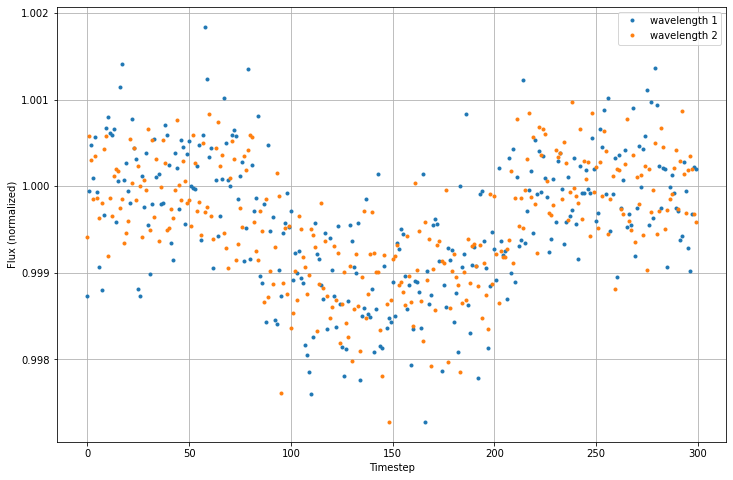

In [4]:
plt.figure(figsize=(12,8))
plt.plot(range(train_data.shape[1]), train_data.iloc[0], '.', label='wavelength 1')
plt.plot(range(train_data.shape[1]), train_data.iloc[1], '.', label='wavelength 2')
plt.legend()
plt.ylabel('Flux (normalized)')
plt.xlabel('Timestep')
plt.grid(True)

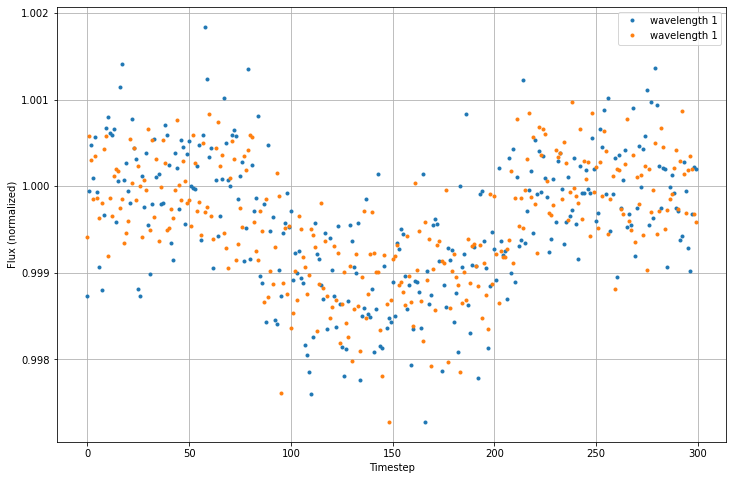

In [24]:
train_data = pd.read_csv(f'{PATH_TRAIN}0001_01_01.txt', sep='\t', skiprows=6, header=None)
plt.figure(figsize=(12,8))
plt.plot(range(train_data.shape[1]), train_data.iloc[0], '.', label='wavelength 1')
plt.plot(range(train_data.shape[1]), train_data.iloc[1], '.', label='wavelength 1')
plt.legend()
plt.ylabel('Flux (normalized)')
plt.xlabel('Timestep')
plt.grid(True)

---

## List of files

In [5]:
list_train_data = glob.glob(f'{PATH_TRAIN}*')

In [6]:
len(list_train_data)

19998

In [7]:
len(set([i.split('/')[4].split('_')[0] for i in list_train_data]))

200

---

## Preprocessing

According to the <a ref=https://arxiv.org/pdf/2010.15996.pdf>paper</a>, the authors made 3 processing steps.

### Smooth data

The fist step is to smooth the data using a mooving median with a window of 3. This process lead to break the fluctuations inside the lightcurve and removed outliers.

### Clip values > 1 to 1 

The relative flux couldn't be superior to 1, so values that superior to 1 are clip to 1.

In [8]:
def median_smooth(lightcurve, window=3):
    j = 0
    new_light = []
    for i in range(len(lightcurve-2)):
        point = np.median(lightcurve[j:j+window])
        if point > 1: point = 1
            new_light.append(point)
        j+=1
    return new_light

In [9]:
new_data_points = []
for i in range(train_data.shape[0]):
    #print(i)
    new_data_points.append(median_smooth(train_data.iloc[i], window=3))

In [10]:
new_train_data = pd.DataFrame(new_data_points)

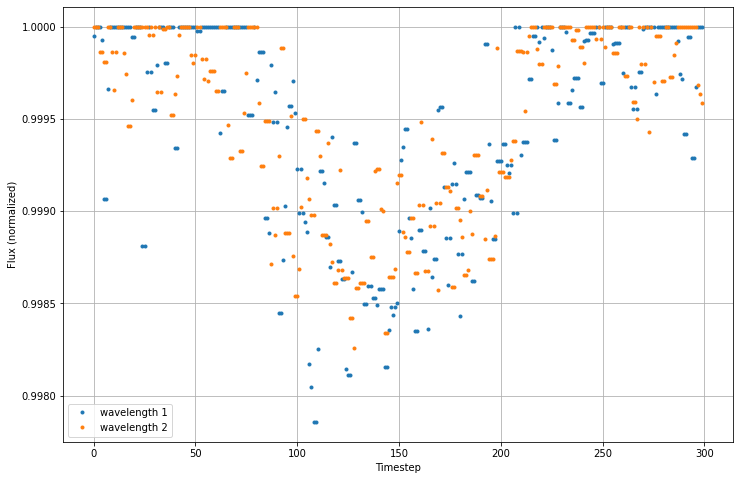

In [11]:
plt.figure(figsize=(12,8))
plt.plot(range(new_train_data.shape[1]), new_train_data.iloc[0], '.', label='wavelength 1')
plt.plot(range(new_train_data.shape[1]), new_train_data.iloc[1], '.', label='wavelength 2')
plt.legend()
plt.ylabel('Flux (normalized)')
plt.xlabel('Timestep')
plt.grid(True)

### Compute average transit depth per wavelength with 10,000 train files  

In [47]:
mean_data = []
for i in tqdm(range(10000)):
    #train_data = pd.read_csv(list_train_data[i], sep='\t', skiprows=6, header=None)
    train_data = np.loadtxt(list_train_data[i], comments='#', delimiter='\t')
    for j in range(len(train_data)):
        train_data[j] = median_smooth(train_data[j], window=3)
    mean_data.append(train_data)

100%|██████████| 10000/10000 [3:28:23<00:00,  1.25s/it] 


In [48]:
mean_data = np.array(mean_data)
mean_wave = []
for i in tqdm(range(mean_data.shape[1])):
    mean_wave.append(np.mean(mean_data[:][i], axis=0))

100%|██████████| 55/55 [00:00<00:00, 20884.19it/s]


In [49]:
np.savetxt(f'{PATH}mean_wavelengths_10000.txt', mean_wave)

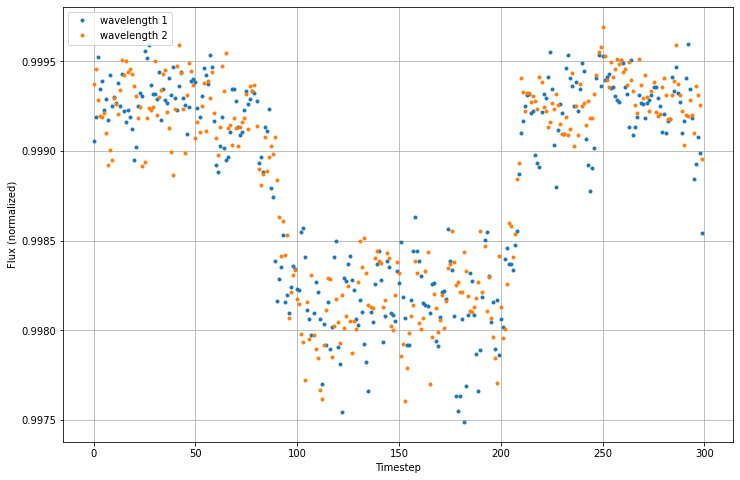

In [46]:

plt.figure(figsize=(12,8))
plt.plot(range(len(mean_wave[0])), mean_wave[0], '.', label='wavelength 1')
plt.plot(range(len(mean_wave[0])), mean_wave[1], '.', label='wavelength 2')
plt.legend()
plt.ylabel('Flux (normalized)')
plt.xlabel('Timestep')
plt.grid(True)

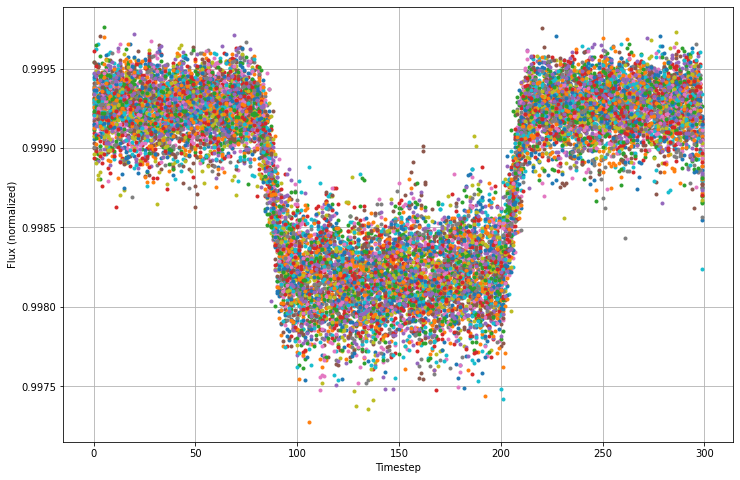

In [3]:
plt.figure(figsize=(12,8))
for i in mean_wave:
    plt.plot(range(len(i)), i, '.', label='wavelength 1')
#plt.plot(range(len(mean_wave)), mean_wave[1], '.', label='wavelength 2')
#plt.legend()
plt.ylabel('Flux (normalized)')
plt.xlabel('Timestep')
plt.grid(True)

In [4]:
mean_wave = np.loadtxt(f'{PATH}mean_wavelengths_10000.txt')

In [5]:
def correct(wave, mean_wave):
    return (wave - (1 - 2*mean_wave**2)) / (2*mean_wave**2)

In [6]:
train_data = np.loadtxt(f'{PATH_TRAIN}0001_01_01.txt')

In [7]:
norm = correct(train_data[0], mean_wave[0])

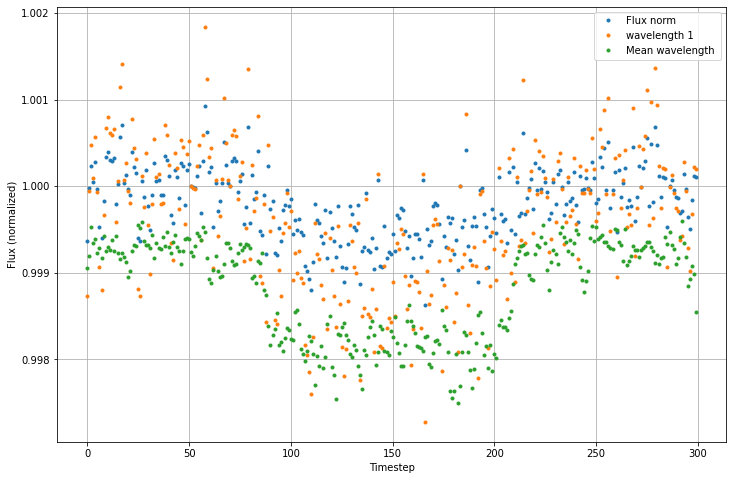

In [11]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm)), norm, '.', label='Flux norm')
plt.plot(range(len(train_data[0])), train_data[0], '.', label='wavelength 1')
plt.plot(range(len(mean_wave[0])), mean_wave[0], '.', label='Mean wavelength ')
#plt.plot(range(len(mean_wave)), mean_wave[1], '.', label='wavelength 2')
plt.legend()
plt.ylabel('Flux (normalized)')
plt.xlabel('Timestep')
plt.grid(True)

### Other normalization

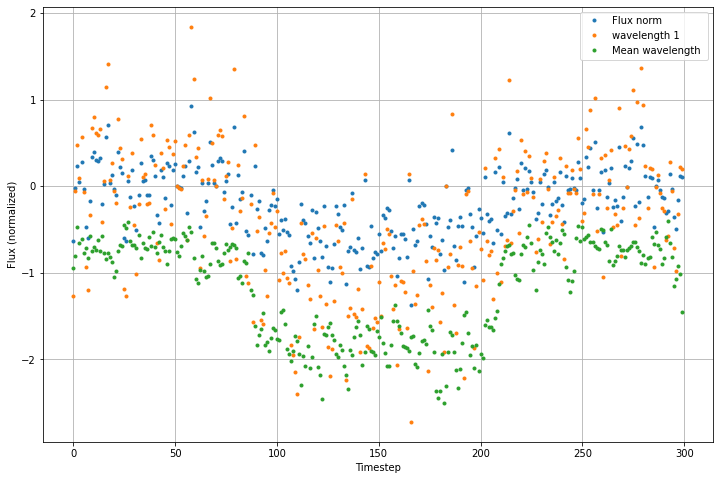

In [13]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm)), (norm-1)*1000, '.', label='Flux norm')
plt.plot(range(len(train_data[0])), (train_data[0]-1)*1000, '.', label='wavelength 1')
plt.plot(range(len(mean_wave[0])), (mean_wave[0]-1)*1000, '.', label='Mean wavelength ')
#plt.plot(range(len(mean_wave)), mean_wave[1], '.', label='wavelength 2')
plt.legend()
plt.ylabel('Flux (normalized)')
plt.xlabel('Timestep')
plt.grid(True)

### Smooth normalization windows 5 

In [71]:
norm_data = []
step = []
j=0
win = 5
for i in range(len(train_data[0])//win):
    norm_data.append(np.mean(train_data[0][j:j+win]))
    step.append(j)
    j+= win

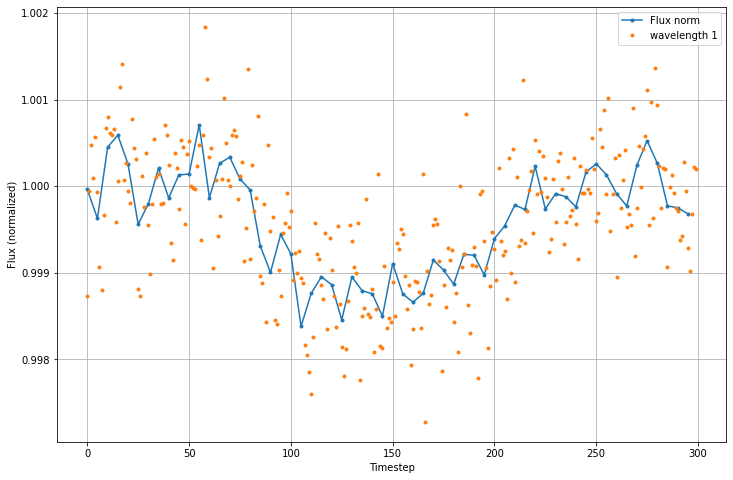

In [72]:
plt.figure(figsize=(12,8))
plt.plot(step, norm_data, '.-', label='Flux norm')
plt.plot(range(len(train_data[0])), train_data[0], '.', label='wavelength 1')
plt.legend()
plt.ylabel('Flux (normalized)')
plt.xlabel('Timestep')
plt.grid(True)

## Datasets creation

In [38]:
with open(f'{PATH_TRAIN}0001_01_01.txt') as f:
    file = f.read()
    header = file.split('\n')[:6]

In [54]:
columns = [i.split()[1] for i in header]

In [55]:
columns

['star_temp:',
 'star_logg:',
 'star_rad:',
 'star_mass:',
 'star_k_mag:',
 'period:']

In [6]:
def extract_data_heads(name, nrows=6):
    '''
    extract planet and solar data, 6 values. 
    
    str -> list 
    '''
    f = open(name, "r")
    _list = re.findall("\d+(?:\.\d+)?",  "".join(f.readlines()[:nrows]))
    return [float(i) for i in _list]

In [158]:
header_data = []
data = []
for i in tqdm(list_train_data[:-2]):
    header_data.append(extract_data_heads(i))
    data.append(np.loadtxt(i))

100%|██████████| 19996/19996 [06:14<00:00, 53.39it/s]


In [159]:
header_data = pd.DataFrame(data=header_data)
#header_data.columns = columns

In [160]:
header_data

,0,1,2,3,4,5
0,6583.133333,4.5,1.093494,1.215178926,9.569,5.835947991
1,6583.133333,4.5,1.093494,1.215178926,9.569,5.835947991
2,6583.133333,4.5,1.093494,1.215178926,9.569,5.835947991
3,6583.133333,4.5,1.093494,1.215178926,9.569,5.835947991
4,6583.133333,4.5,1.093494,1.215178926,9.569,5.835947991
...,...,...,...,...,...,...
19991,3601.008333,5.0,0.4255,0.4475,9.392,14.4883996
19992,3601.008333,5.0,0.4255,0.4475,9.392,14.4883996
19993,3601.008333,5.0,0.4255,0.4475,9.392,14.4883996
19994,3601.008333,5.0,0.4255,0.4475,9.392,14.4883996


In [74]:
data[:2]

[array([[0.99873317, 0.9999484 , 1.00047361, ..., 0.99967524, 1.00022661,
         1.00020105],
        [0.99941677, 1.00058066, 1.00030044, ..., 1.00019571, 0.99968276,
         0.99958839],
        [1.00048908, 1.00065233, 0.99920017, ..., 1.00030815, 0.99938912,
         1.0002047 ],
        ...,
        [0.99857853, 1.00738733, 1.00074341, ..., 1.00798265, 0.99703256,
         0.99289291],
        [0.99939888, 1.00029472, 0.99843995, ..., 1.00328642, 0.99908723,
         0.99206337],
        [0.99457976, 1.00308485, 1.00801707, ..., 0.99466096, 1.00353241,
         0.99840534]]),
 array([[1.00069622, 1.0010563 , 1.00033651, ..., 1.00127007, 0.99974069,
         1.00021792],
        [0.99986038, 1.00035015, 1.00044435, ..., 1.0008795 , 0.99985241,
         1.00068948],
        [0.99943885, 0.99952537, 0.99981314, ..., 1.00025513, 1.00009776,
         0.99970063],
        ...,
        [1.00125681, 1.00389873, 0.99868288, ..., 1.00103031, 0.99653852,
         0.99719564],
        [0.9

### What about the labels?

The target are provided in the parameters dataset (see above).

In [76]:
list_params_train = glob.glob(f'{PATH_PARAM}*.txt')

In [77]:
print(list_params_train[0])
print(len(list_params_train))

../Datasets/ariel_data/params_train/0001_01_01.txt
20000


In [55]:
with open(f'{PATH_PARAM}0001_01_01.txt', 'r') as file:
    f = file.read()

In [56]:
f

'# sma: 10127890523\n# incl: 86.58117003\n0.0347457182932\t0.0342461799266\t0.0360616697594\t0.0378428507367\t0.0367786884829\t0.0389816024171\t0.0379012733339\t0.0393670933541\t0.0388116252372\t0.0382923880588\t0.0381699039436\t0.038070026863\t0.0383454653966\t0.0390066686803\t0.0399485206038\t0.041034095045\t0.0413712520321\t0.0415718188205\t0.0418109574635\t0.0415532141232\t0.0412884768485\t0.0410552392241\t0.0407902388604\t0.0405397286152\t0.0400566211549\t0.0397726261276\t0.0395436376145\t0.0396233995304\t0.0397418379345\t0.0400643541872\t0.0404211805331\t0.0418309919193\t0.0433895261799\t0.044141751622\t0.0438375298642\t0.0440749376011\t0.0444521789304\t0.0436821190334\t0.0435526622431\t0.0432490566634\t0.0424732325347\t0.0416591886784\t0.0410498452185\t0.040535824002\t0.0397684255944\t0.0388488073149\t0.0384330764454\t0.0392627945599\t0.0400622458145\t0.0406358560093\t0.0410560457718\t0.0413418248897\t0.0414706364127\t0.0436200592834\t0.0440568952457\n'

In [58]:
extract_data_heads(list_param_data[0], nrows=2)

[10127890523.0, 86.58117003]

### Build npy matrices with all the data

In [2]:
list_train_data = glob.glob(f'{PATH_TRAIN}*.txt')
list_param_data = glob.glob(f'{PATH_PARAM}*.txt')
list_test_data  = glob.glob(f'{PATH_TEST}*.txt')

In [3]:
print(f'Number of files in the train: {len(list_train_data)} ; number of files for the parameters: {len(list_param_data)} ; number of files for the parameters: {len(list_test_data)}')

Number of files in the train: 146800 ; number of files for the parameters: 146800 ; number of files for the parameters: 62900


In [4]:
def generate_npy_data(list_files, train_head=6, test_head=6, param_head=2,save=False):
    
    
    for i in list_files:
        #print(i)
        if "noisy_train" in i[0]:
            print("train")
            train_header_data = []
            train_data = []
            for j in tqdm(i):
                train_header_data.append(extract_data_heads(j, train_head))
                train_data.append(np.loadtxt(j))
            if save:
                with open(f'{PATH}train_data_ariel.npy', 'wb') as f:
                    np.save(f, train_data)
                with open(f'{PATH}header_train_data_ariel.npy', 'wb') as f:
                    np.save(f, train_header_data)
                with open(f'{PATH}train_data_ariel_75000.npy', 'wb') as f:
                    np.save(f, train_data[:75000])
                with open(f'{PATH}header_train_data_ariel_75000.npy', 'wb') as f:
                    np.save(f, train_header_data[:75000])
        if "noisy_test" in i[1]:
            print("test")
            test_header_data = []
            test_data = []
            for j in tqdm(i):
                test_header_data.append(extract_data_heads(j, test_head))
                test_data.append(np.loadtxt(j))
            if save:
                with open(f'{PATH}test_data_ariel.npy', 'wb') as f:
                    np.save(f, test_data)
                with open(f'{PATH}header_test_data_ariel.npy', 'wb') as f:
                    np.save(f, test_header_data)
                with open(f'{PATH}test_data_ariel_34000.npy', 'wb') as f:
                    np.save(f, test_data[:34000])
                with open(f'{PATH}header_test_data_ariel_34000.npy', 'wb') as f:
                    np.save(f, test_header_data[:34000])
        if 'param' in i[2]:
            print("param")
            param_header_data = []
            param_train_data = []
            for j in tqdm(i):
                param_header_data.append(extract_data_heads(j, param_head))
                param_train_data.append(np.loadtxt(j))
            if save:
                with open(f'{PATH}param_train_data_ariel.npy', 'wb') as f:
                    np.save(f, param_train_data)
                with open(f'{PATH}header_param_data_ariel.npy', 'wb') as f:
                    np.save(f, param_header_data)
                with open(f'{PATH}param_train_data_ariel_75000.npy', 'wb') as f:
                    np.save(f, param_train_data[:75000])
                with open(f'{PATH}header_param_data_ariel_75000.npy', 'wb') as f:
                    np.save(f, param_header_data[:75000])
                    
    return train_data, train_header_data, test_data, test_header_data, param_train_data, param_header_data

In [7]:
_list = [list_train_data, list_param_data, list_test_data]
train_data, train_header_data, test_data, test_header_data, param_train_data, param_header_data = generate_npy_data(_list, train_head=6, test_head=6, param_head=2,save=True)

  0%|          | 3/146800 [00:00<2:16:37, 17.91it/s]

train


  0%|          | 2/146800 [00:00<2:09:39, 18.87it/s]

param


  0%|          | 1/62900 [00:00<1:49:57,  9.53it/s]

test


100%|██████████| 62900/62900 [37:21<00:00, 28.06it/s]  


### Load npy files

In [8]:
train_data = np.load(f'{PATH}train_data_ariel.npy')[:30000]
param_train_data = np.load(f'{PATH}param_data_ariel.npy')[:30000]
test_data  = np.load(f'{PATH}test_data_ariel.npy')[:5000]

In [9]:
train_header_data = np.load(f'{PATH}header_data_ariel.npy')[:30000]
test_header_data = np.load(f'{PATH}header_test_data_ariel.npy')[:5000]

## Prepare train test

In [11]:

all_data = train_data.reshape(-1,55*300)
del train_data
all_data = (all_data-1)*1000
all_data = all_data.reshape(-1,55,300)
all_params = param_train_data.reshape(-1,55)
del param_train_data
all_header_data = train_header_data.astype(float)


In [12]:
print(all_data.shape, all_params.shape, all_header_data.shape)

(30000, 55, 300) (30000, 55) (30000, 6)


In [13]:
X_train, X_test,y_train, y_test =train_test_split(all_data, all_params, random_state=42)
head_train, head_test = train_test_split(all_header_data, random_state=42)

In [14]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

22500 22500 7500 7500


## Models

In [ ]:
_model = model()

In [ ]:
weights_file = f"{PATH_WEIGHTS}ANN4_weights.h5"

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15,  mode= 'min')
checkpoint = keras.callbacks.ModelCheckpoint(weights_file, monitor='val_loss',  save_best_only=True, mode='min')


In [ ]:
calls = [early_stopping, checkpoint, keras.callbacks.TerminateOnNaN()]

In [ ]:
_model.fit([ X_train, head_train], y_train, epochs=1000, batch_size=64,
                  validation_data=([ X_test, head_test], y_test), callbacks=calls)

## Prediction and score

In [ ]:
list_test = glob.glob(f'{PATH_TEST}*.txt')

In [174]:
header_test = []
test = []
for i in tqdm(list_test[:-2]):
    header_test.append(extract_data_heads(i))
    test.append(np.loadtxt(i))

100%|██████████| 4998/4998 [03:18<00:00, 25.24it/s]


In [18]:
test_pred = test_data.reshape(-1,55*300)
del test_data
test_pred = (test_pred-1)*1000
test_pred = test_pred.reshape(-1,55,300)
all_header_test = test_header_data.astype(float)

In [ ]:
_model.load_weights(weights_file)
y_pred =  _model.predict([test_pred,all_header_test])
score(weights[:len(test_pred)], truedata[:len(test_pred)], y_pred)

---

## Cross-validation

---

Let's go, time to run the different models in cross-validation. Each folds will be saved.

In [ ]:
def scheduler(epoch, lr):
   '''
   Make a learning rate decay 
   @param epoch: (int) number of epoch
   @param lr: (float) value of the learning rate
   @return (float) learning rate with decay
   '''
   if epoch < 25:
    return lr
   else:
    return lr * tf.math.exp(-0.1) # decrease the learning rate each 25 epochs

In [ ]:
def score_folds(name, model):
    '''
    @param name: (str) name of the model
    @param model: (keras model) instance of a model
    @return resultats: (list) contains the score of each folds 
    '''
    PATH = PATH_WEIGHTS
    NAME = name
    list_models = glob.glob(f'{PATH}{NAME}_fold*')
    resultats =  []
    _model_ = tf.keras.models.clone_model(model)
    for i in enumerate(list_models):
        _model_.load_weights(i[1])
        y_pred =  _model_.predict([test_pred,all_header_test])
        res = score(weights[:len(test_pred)], truedata[:len(test_pred)], y_pred)
        print(f'Score for fold {i[0]}: {res}')
        resultats.append(res)

    _model_.load_weights(f'{PATH}{NAME}_Overall.h5')
    y_pred =  _model_.predict([test_pred,all_header_test])
    res = score(weights[:len(test_pred)], truedata[:len(test_pred)], y_pred)
    print(f'Score Overall: {res}')
    resultats.append(res)
    return resultats 

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import time
import keras.backend as K
from sklearn.metrics import mean_squared_error as mse 

def cross_validate_NN(model, X, y, X_test, y_test, name="NN", fold='default',  n_splits=10, batch_size = 32,  use_multiprocessing=True, path='.'):
    '''
    Function create a metric report automatically with cross_validate function.
    @param model: (model) neural network model
    @param X: (list or matrix or tensor) training X data
    @param y: (list) label data 
    @param X_test: (list or matrix or tensor) testing X data
    @param y_test: (list) label test data 
    @param name: (string) name of the model (default NN)
    @param fold: (str) stratified or kflod (default stratified)
    @param n_splits: (int) number of fold for cross-validation (default 10)
    @param batch_size: 
    @param use_multiprocessing:
    @param path: (str)
    @return: (pandas.dataframe) dataframe containing all the results of the metrics 
    for each fold and the mean and std for each of them
    '''
    # ---- Parameters initialisation
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25)
    seed = 42
    k = 1
    np.random.seed(seed)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # ---- Folds 
    if fold=='default':
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    else:
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
   
    # ---- Dict to store the results and metrics
    dic_score = dict()
    dic_history = dict()
    dic_score["Model"] = name
    dic_history["Model"] = name

    # ---- Loop on k-fold for cross-valisation
    
    for train, test in kfold.split(X[0], y):   # training NN on each fold 
        # ---- create model
        print(f"k-fold : {k}")
        fit_start = time.time()     # save time 
        _model = tf.keras.models.clone_model(model) # clone the initial model to begin with a new clean model
        _model.compile(optimizer='nadam',
                  loss='mse',
                  metrics=['mse'])
        
        save_model = f'{path}'+name+f'_fold_{k}.h5'     # save each folds 
        checkpoint = keras.callbacks.ModelCheckpoint(save_model, monitor='val_loss',  save_best_only=True, mode='min') # save the best parameters of the best iteration
        calls = [early_stopping, checkpoint, scheduler_lr, keras.callbacks.TerminateOnNaN()]
        # ---- Train the model 
        history = _model.fit([X[0][train], X[1][train]], y[train],
                        epochs=1000, callbacks=calls, validation_data=([X[0][test], X[1][test]], y[test]),
                         verbose=False, batch_size = batch_size,  use_multiprocessing=use_multiprocessing)
        fit_end = time.time() - fit_start   # save the end time 
        
        score_start = time.time()
        _model.load_weights(save_model)
        y_pred = _model.predict([X[0][test], X[1][test]])
        score_end = time.time() - score_start
        metric = mse(y[test], y_pred)

        # ---- Save the metrics 
        print(f"\nMSE for the fold {k}: {round(metric, 10)} \n")
        dic_score[f"Fit_time_fold_{k}"] = fit_end   # initialisation for time fitting and scoring
        dic_score[f"Inference_time_fold_{k}"] = score_end
        dic_score[f"MSE_fold_{k}"] = round(metric, 10)
        dic_history["History"+f'_fold_{k}'] = history

        # ---- Clean the session
        K.clear_session()
        del _model
        k+=1
    
    # Train test on the overall data
    print("Overall train-test data")
    fit_start = time.time()
    _model = tf.keras.models.clone_model(model)
    _model.compile(optimizer='nadam',
                  loss='mse',
                  metrics=['mse'])
    
    save_model = f'{path}'+name+'_Overall.h5'     # save each folds 
    checkpoint = keras.callbacks.ModelCheckpoint(save_model, monitor='val_loss',  save_best_only=True, mode='min')
    calls = [early_stopping, checkpoint, scheduler_lr, keras.callbacks.TerminateOnNaN()]
    history = _model.fit(X, y,epochs=1000, callbacks=calls, validation_split=0.1, batch_size = batch_size, 
                   verbose=0, use_multiprocessing=use_multiprocessing)
        
    fit_end = time.time() - fit_start
    
    score_start = time.time()
    _model.load_weights(save_model)
    y_pred = _model.predict(X_test)
    score_end = time.time() - score_start
    metric = mse(y_test, y_pred)

    dic_score["Fit_time_Overall"] = fit_end   # initialisation for time fitting and scoring
    dic_score["Inference_time_Overall"] = score_end
    dic_score["MSE_Overall"] = round(metric, 10)
    dic_history["History_Overall"] = history
    print(f"\nMSE Overall: {round(metric, 10)} \n")
    
    return dic_score, dic_history, _model

Using TensorFlow backend.


In [ ]:
test_models = {
    'ANN'        : model(layer_1=512, layer_2=256, layer_3=128),
    'ANN2'       : model(layer_1=1024, layer_2=512, layer_3=256),
    'cnn1D'      : cnn_1D(),
    'lstm'       : lstm(activation_1='tanh'),
    'GRU'        : gru(activation_1='tanh'),
    'bi_lstm'    : bi_lstm(activation_1='tanh'),
    'attention'  : attention(activation_1='tanh'),
    'attention2' : attention2(activation_1='tanh')
}

In [ ]:
dict_results = dict()
for i in test_models.items():
    res_model, histories, _model_ = cross_validate_NN(i[1], [X_train, head_train], y_train, [ X_test, head_test], y_test,
                              name=i[0], fold='no',  n_splits=10, batch_size = 128, path=PATH_WEIGHTS)
    dict_results[i[0]] = score_folds(i[0], i[1])
    